# Sushi detection with Yolo v11

In [1]:
!pip install ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00


In [2]:
!pip -q install "transformers>=4.41" "accelerate>=0.30" timm supervision \
  opencv-python-headless pillow torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Raw data conversion to Yolo format

In [5]:
import pandas as pd
from pathlib import Path
import requests
import glob
from concurrent.futures import ThreadPoolExecutor

IMAGE_SCRAPER_RAW_DATA_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/image-scraper-raw-data")


def filter_valid(urls):
    with ThreadPoolExecutor(max_workers=50) as executor:
        results = list(executor.map(is_valid_url, urls))
    return [u for u, ok in zip(urls, results) if ok]
# Folder with your CSVs

def is_valid_url(url: str) -> bool:
    try:
        r = requests.head(url, allow_redirects=True, timeout=5)
        if r.status_code == 405:  # some servers reject HEAD
            r = requests.get(url, stream=True, timeout=5)
        return r.status_code == 200
    except requests.RequestException:
        return False

all_dicts = {}

for csv_file in IMAGE_SCRAPER_RAW_DATA_DIR.glob("*.csv"):
    df = pd.read_csv(csv_file, names=['path'], header=None)
    valid_urls = filter_valid(df['path'].tolist())
    all_dicts[csv_file.stem] = valid_urls
    print(f"✅ {csv_file.name}: {len(valid_urls)} valid URLs out of {len(df)}")

# Now all_dicts has the structure you want
print("\nFinished!\n")
print(all_dicts.keys())  # just to see which CSVs were processed

✅ amberjack.csv: 44 valid URLs out of 80
✅ salmon.csv: 48 valid URLs out of 80
✅ halibut fin.csv: 44 valid URLs out of 80
✅ ark clam.csv: 37 valid URLs out of 80
✅ mackerel.csv: 47 valid URLs out of 80
✅ sea urchin.csv: 47 valid URLs out of 80
✅ squid.csv: 51 valid URLs out of 80
✅ octopus.csv: 40 valid URLs out of 80
✅ shrimp.csv: 61 valid URLs out of 80
✅ shad.csv: 14 valid URLs out of 28
✅ salmon roe.csv: 51 valid URLs out of 80
✅ crab.csv: 49 valid URLs out of 80
✅ spanish mackerel.csv: 44 valid URLs out of 80
✅ bonito.csv: 34 valid URLs out of 80
✅ fatty tuna.csv: 16 valid URLs out of 28
✅ sea bream.csv: 16 valid URLs out of 28
✅ tuna.csv: 50 valid URLs out of 80
✅ sardine.csv: 41 valid URLs out of 80
✅ sea eel.csv: 18 valid URLs out of 28
✅ yellowtail fish.csv: 16 valid URLs out of 28
✅ surf clam.csv: 50 valid URLs out of 80
✅ eel.csv: 39 valid URLs out of 80
✅ scallop.csv: 16 valid URLs out of 28
✅ whelk.csv: 37 valid URLs out of 80
✅ egg.csv: 46 valid URLs out of 80

Finished!


In [6]:
# Remove files in data folder
import shutil

# Paths
IMG_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/train/images")
LBL_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/train/labels")

# Clean up existing folders
for d in [IMG_DIR, LBL_DIR]:
    if d.exists():
        shutil.rmtree(d)   # deletes the folder and everything inside
    d.mkdir(parents=True, exist_ok=True)

In [7]:
from pathlib import Path
import cv2, torch, requests, numpy as np
import supervision as sv
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from urllib.parse import urlparse
import hashlib

# --- your existing constants/classes/prompts/model setup above this line ---

IMG_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/train/images")
LBL_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/train/labels")
IMG_DIR.mkdir(parents=True, exist_ok=True)
LBL_DIR.mkdir(parents=True, exist_ok=True)

BOX_THR       = 0.10        # OWL-ViT score threshold
NMS_IOU       = 0.50        # IoU for NMS
MAX_LONG_SIDE = 1280        # resize cap for longer side
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# OWL-ViT setup if not already done
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model     = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(DEVICE).eval()

import random, string

def normalize_key(s: str) -> str:
    """Lowercase + strip spaces to normalize class names."""
    return s.strip().lower().replace(" ", "_")

CLASSES = [
  'salmon', 'tuna', 'mackerel', 'spanish mackerel', 'sea eel', 'eel',
  'egg', 'salmon roe', 'shrimp', 'sea bream', 'whelk', 'yellowtail fish',
  'surf clam', 'halibut fin', 'octopus', 'squid', 'amberjack', 'sardine',
  'sea urchin', 'scallop', 'ark clam', 'crab', 'bonito', 'shad', 'fatty tuna'
]

if "ALIASES" not in globals():
    ALIASES = {}

name2id = {normalize_key(c): i for i, c in enumerate(CLASSES)}

prompts = {normalize_key(c): [c] for c in CLASSES}

def safe_filename(path_or_url: str, class_name: str = None, length: int = 8) -> str:
    """Generate a filename like class_randomletters."""
    rand_str = ''.join(random.choices(string.ascii_lowercase + string.digits, k=length))
    if class_name:
        stem = f"{class_name}_{rand_str}"
    else:
        stem = rand_str
    return stem.lower()

def imread_any(path_or_url: str):
    if str(path_or_url).startswith(("http://","https://")):
        r = requests.get(path_or_url, timeout=10)
        r.raise_for_status()
        arr = np.frombuffer(r.content, dtype=np.uint8)
        return cv2.imdecode(arr, cv2.IMREAD_COLOR)
    return cv2.imread(str(path_or_url))

def save_image_copy(img, filename_stem: str):
    out_path = IMG_DIR / f"{filename_stem}.jpg"
    cv2.imwrite(str(out_path), img)
    return out_path

def resize_long_side(img, max_side=1280):
    h, w = img.shape[:2]
    m = max(h, w)
    if m <= max_side:
        return img, 1.0
    s = max_side / m
    return cv2.resize(img, (int(w*s), int(h*s))), s

def to_yolo(xyxy, w, h):
    x1,y1,x2,y2 = xyxy
    bw, bh = x2-x1, y2-y1
    cx, cy = x1 + bw/2, y1 + bh/2
    return cx/w, cy/h, bw/w, bh/h

@torch.inference_mode()
def owl_predict(img_bgr, texts):
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    inputs = processor(text=texts, images=rgb, return_tensors="pt").to(DEVICE)
    outputs = model(**inputs)
    target_sizes = torch.tensor([rgb.shape[:2]]).to(DEVICE)  # (h, w)
    try:
        results = processor.post_process_grounded_object_detection(
            outputs=outputs, target_sizes=target_sizes, text_queries=texts, threshold=BOX_THR
        )[0]
    except Exception:
        results = processor.post_process_object_detection(
            outputs=outputs, target_sizes=target_sizes, threshold=BOX_THR
        )[0]
    boxes  = results.get("boxes",  torch.empty((0,4), device=DEVICE)).detach().cpu().numpy()
    scores = results.get("scores", torch.empty((0,),   device=DEVICE)).detach().cpu().numpy()
    labels = results.get("labels", torch.empty((0,),   device=DEVICE, dtype=torch.long)).detach().cpu().numpy()
    return boxes, scores, labels

def apply_nms_with_supervision(dets, iou=NMS_IOU, class_agnostic=False):
    try:
        return dets.with_nms(class_agnostic=class_agnostic, iou_threshold=iou)
    except TypeError:
        try:
            return dets.with_nms(iou, class_agnostic=class_agnostic)
        except TypeError:
            return dets

# ---------------- Main loop (ensures a label file is always created) ----------------
for raw_class_name, paths in all_dicts.items():
    key = normalize_key(raw_class_name)
    if key not in name2id and key in ALIASES:
        key = ALIASES[key]
    if key not in name2id:
        print(f"[warn] Unknown class key: '{raw_class_name}' -> '{key}'. Skipping.")
        continue

    cls_id = name2id[key]
    texts = prompts[key]

    for src in paths:
        img = imread_any(src)
        if img is None:
            print(f"[warn] cannot read image: {src}")
            continue

        # stable filename (also used for label)
        filename = safe_filename(src, key)
        save_image_copy(img, filename)  # persist the image

        H, W = img.shape[:2]
        img_in, scale = resize_long_side(img, MAX_LONG_SIDE)

        boxes, scores, _ = owl_predict(img_in, texts)
        if scale != 1.0 and boxes.shape[0] > 0:
            boxes = boxes / scale

        lines = []

        if boxes.shape[0] > 0:
            dets = sv.Detections(
                xyxy=boxes,
                confidence=scores,
                class_id=np.full(len(boxes), cls_id, dtype=int)
            )
            dets = apply_nms_with_supervision(dets, iou=NMS_IOU, class_agnostic=False)

            # keep reasonable boxes; if none survive, we'll fallback
            for (x1,y1,x2,y2) in dets.xyxy:
                bw, bh = (x2-x1), (y2-y1)
                area = (bw*bh)/(W*H)
                if area < 0.0005 or area > 0.95:
                    continue
                cx, cy, ww, hh = to_yolo((x1,y1,x2,y2), W, H)
                lines.append(f"{int(cls_id)} {cx:.6f} {cy:.6f} {ww:.6f} {hh:.6f}")

        # ---------- Fallback: no boxes? write full-image box ----------
        if not lines:
            # use 0.999 instead of 1.0 to avoid edge clipping in some tools
            lines = [f"{int(cls_id)} {0.5:.6f} {0.5:.6f} {0.999:.6f} {0.999:.6f}"]

        # write label file (always)
        (LBL_DIR / f"{filename}.txt").write_text("\n".join(lines))

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

In [8]:
# Remove files in data folder
import shutil

# Paths
IMG_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/valid/images")
LBL_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/valid/labels")

# Clean up existing folders
for d in [IMG_DIR, LBL_DIR]:
    if d.exists():
        shutil.rmtree(d)   # deletes the folder and everything inside
    d.mkdir(parents=True, exist_ok=True)

# Take 20% of data and move it to the valid folder

import os, random, shutil
from pathlib import Path

# Base paths
BASE = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data")
TRAIN_IMG = BASE / "train/images"
TRAIN_LBL = BASE / "train/labels"
VALID_IMG = BASE / "valid/images"
VALID_LBL = BASE / "valid/labels"

# Make sure valid dirs exist
VALID_IMG.mkdir(parents=True, exist_ok=True)
VALID_LBL.mkdir(parents=True, exist_ok=True)

# List image files (assume images are .jpg or .png)
img_exts = {".jpg", ".jpeg", ".png", ".bmp"}
train_images = [f for f in TRAIN_IMG.iterdir() if f.suffix.lower() in img_exts]

print(f"Total train images: {len(train_images)}")
print(f"Total train labels: {len(list(TRAIN_LBL.glob('*.txt')))}")

# Take 20%
valid_count = int(len(train_images) * 0.2)
valid_samples = random.sample(train_images, valid_count)

print(f"Moving {valid_count} samples to valid set...")

for img_path in valid_samples:
    # Corresponding label
    label_path = TRAIN_LBL / (img_path.stem + ".txt")

    # Move image
    shutil.move(str(img_path), str(VALID_IMG / img_path.name))

    # Move label (if exists)
    if label_path.exists():
        shutil.move(str(label_path), str(VALID_LBL / label_path.name))

print("✅ Done!")
print(f"Now train has {len(list(TRAIN_IMG.glob('*')))} images, valid has {len(list(VALID_IMG.glob('*')))} images.")

Total train images: 956
Total train labels: 956
Moving 191 samples to valid set...
✅ Done!
Now train has 765 images, valid has 191 images.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


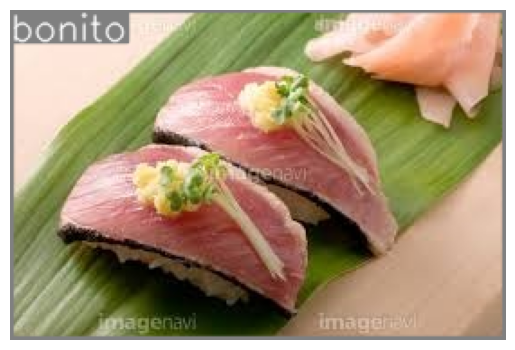

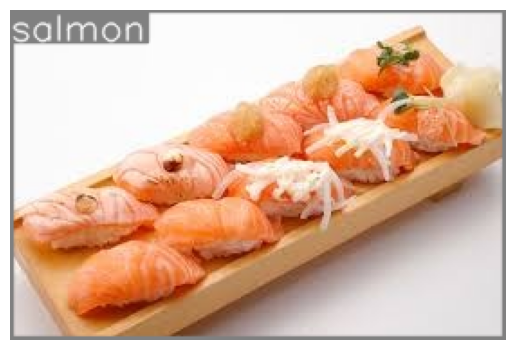

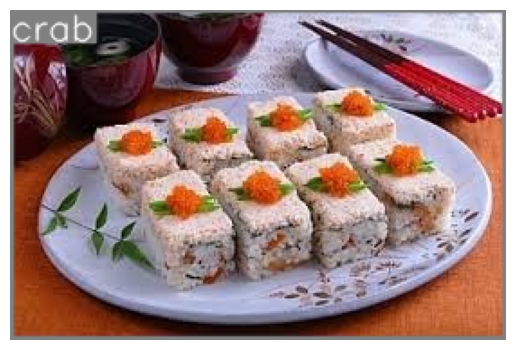

In [9]:
import cv2, random
from ultralytics.utils.plotting import Annotator
from matplotlib import pyplot as plt

YAML = "/content/drive/MyDrive/yolo-sushi-detection-data/data.yaml"
DATA = "/content/drive/MyDrive/yolo-sushi-detection-data/data"

def show_gt(img_path: Path, names):
    im = cv2.imread(str(img_path))
    H,W = im.shape[:2]
    lbl = Path(str(img_path).replace("/images/","/labels/")).with_suffix(".txt")
    ann = Annotator(im.copy(), line_width=2)
    if lbl.exists():
        for line in open(lbl):
            c,x,y,w,h = map(float, line.split())
            c=int(c)
            x1=int((x-w/2)*W); y1=int((y-h/2)*H)
            x2=int((x+w/2)*W); y2=int((y+h/2)*H)
            ann.box_label([x1,y1,x2,y2], names[c])
    plt.imshow(cv2.cvtColor(ann.result(), cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()

import yaml, glob
names = yaml.safe_load(open(YAML))["names"]
sample_imgs = glob.glob(f"{DATA}/valid/images/*")
for p in random.sample(sample_imgs, min(3, len(sample_imgs))):
    show_gt(Path(p), names)

In [10]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

In [11]:
results = model.train(
    data="/content/drive/MyDrive/yolo-sushi-detection-data/data.yaml",
    epochs=10,
    batch=4,
    imgsz=416,
    model="yolo11n.pt",
    patience=20,
    seed=0
)

Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo-sushi-detection-data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots

Overriding model.yaml nc=80 with nc=25

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

YOLO11n summary: 181 layers, 2,594,715 parameters, 2,594,699 gradients

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 12.7±7.0 MB/s, size: 16.8 KB)


train: Scanning /content/drive/MyDrive/yolo-sushi-detection-data/data/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:03<00:00, 199.18it/s]


train: New cache created: /content/drive/MyDrive/yolo-sushi-detection-data/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 8.7±5.2 MB/s, size: 15.9 KB)


val: Scanning /content/drive/MyDrive/yolo-sushi-detection-data/data/valid/labels... 191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191/191 [00:00<00:00, 200.48it/s]

val: New cache created: /content/drive/MyDrive/yolo-sushi-detection-data/data/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000345, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
       1/10     0.898G     0.3812      4.071      1.099          1        416: 100%|██████████| 192/192 [00:25<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193     0.0227      0.903     0.0704      0.067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
       2/10     0.914G     0.2273      3.759     0.9761          1        416: 100%|██████████| 192/192 [00:21<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193     0.0326      0.953     0.0972     0.0959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
       3/10     0.928G     0.2328      3.484     0.9732          1        416: 100%|██████████| 192/192 [00:41<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193       0.24      0.414      0.109      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
       4/10     0.928G      0.221      3.265     0.9542          1        416: 100%|██████████| 192/192 [00:20<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193      0.204      0.361      0.151      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
       5/10     0.943G     0.1959      3.085     0.9541          1        416: 100%|██████████| 192/192 [00:21<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193      0.233      0.242      0.186      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
       6/10     0.957G     0.1861      2.925     0.9338          1        416: 100%|██████████| 192/192 [00:21<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193      0.236      0.416      0.213      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
       7/10     0.957G     0.1771       2.81     0.9395          1        416: 100%|██████████| 192/192 [00:20<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193      0.318      0.313      0.248      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
       8/10     0.957G     0.1719      2.728     0.9378          1        416: 100%|██████████| 192/192 [00:29<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193        0.3      0.313      0.224       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
       9/10     0.973G     0.1497       2.66     0.9375          1        416: 100%|██████████| 192/192 [00:20<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193      0.302      0.341      0.238      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/192 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
      10/10     0.986G     0.1423      2.627     0.9226          1        416: 100%|██████████| 192/192 [00:20<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` 

                   all        191        193       0.28      0.351      0.251      0.245



10 epochs completed in 0.075 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,587,027 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/24 [00:00<?, ?it/s]UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 15.00it/s]


                   all        191        193      0.278       0.35       0.25      0.244
                salmon         11         11      0.373      0.727      0.632      0.529
                  tuna         13         13       0.39      0.923      0.645      0.645
              mackerel          9          9       0.14      0.333      0.138      0.138
      spanish mackerel         14         14      0.227      0.286      0.245      0.245
               sea eel          6          6     0.0939      0.167      0.125      0.125
                   eel          4          4      0.136       0.75      0.566      0.566
                   egg         10         10      0.328        0.6      0.445      0.445
            salmon roe          8          8      0.363        0.5       0.45       0.45
                shrimp          8          9      0.154      0.333      0.116        0.1
             sea bream          2          2          0          0      0.073      0.073
                 whel

In [12]:
# Validate on your val set
model.val(data="/content/drive/MyDrive/yolo-sushi-detection-data/data.yaml")

# Predict with low conf to inspect weak signals
pred = model(img, conf=0.05, imgsz=416)
for r in pred:
    for c, p in zip(r.boxes.cls.tolist(), r.boxes.conf.tolist()):
        print(r.names[int(c)], f"{p:.3f}")

Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,587,027 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 16.0±9.5 MB/s, size: 17.2 KB)


val: Scanning /content/drive/MyDrive/yolo-sushi-detection-data/data/valid/labels.cache... 191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191/191 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 23.58it/s]


                   all        191        193      0.266      0.338      0.248      0.243
                salmon         11         11      0.362      0.672      0.632      0.529
                  tuna         13         13      0.393      0.923      0.635      0.635
              mackerel          9          9      0.151      0.333      0.139      0.139
      spanish mackerel         14         14      0.263      0.286      0.243      0.243
               sea eel          6          6     0.0936      0.167      0.126      0.126
                   eel          4          4      0.145       0.75       0.57       0.57
                   egg         10         10      0.361        0.6      0.438      0.438
            salmon roe          8          8      0.314      0.375       0.44       0.44
                shrimp          8          9      0.179      0.333      0.133      0.114
             sea bream          2          2          0          0     0.0729     0.0729
                 whel


0: 320x416 1 tuna, 1 spanish mackerel, 1 bonito, 46.1ms
Speed: 1.5ms preprocess, 46.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 416)


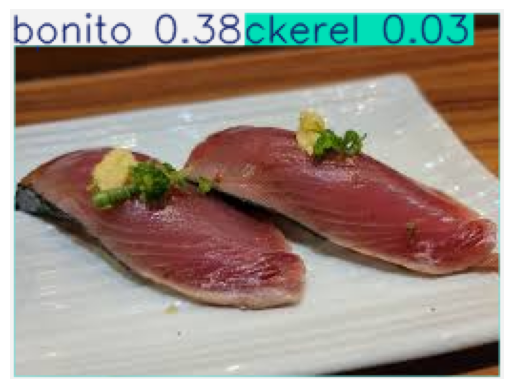

classes: [22.0, 1.0, 3.0]
confs  : [0.37522363662719727, 0.10083062946796417, 0.029590878635644913]
xyxy   : [[0.0, 0.8791548609733582, 258.89581298828125, 194.0], [0.05190834403038025, 0.5939629673957825, 258.8882141113281, 194.0], [0.0, 0.9612733721733093, 258.9169006347656, 194.0]]


In [13]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Download the image from URL
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQzcD8bGNm8wOoQOpLvVM6N35GrDqSxAGnicw&s"
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB")

# Run model inference
results = model(img, conf=0.01, iou=0.7, imgsz=416, verbose=True)

# Visualize
for r in results:
    im = r.plot()[..., ::-1]
    plt.imshow(im); plt.axis("off"); plt.show()

# Print detected boxes: class id, confidence, xyxy
for r in results:
    if r.boxes is not None and len(r.boxes) > 0:
        print("classes:", r.boxes.cls.tolist())
        print("confs  :", r.boxes.conf.tolist())
        print("xyxy   :", r.boxes.xyxy.tolist())
    else:
        print("No boxes even at low conf.")

In [ ]:
# clear outputs/metadata

# clear outputs/metadata

SRC = "sushi-detection.ipynb"          # <-- change me
DST = "sushi-detection_clean.ipynb"    # <-- change me

import json, nbformat

WIDGET_MIMES = {
    "application/vnd.jupyter.widget-view+json",
    "application/vnd.jupyter.widget-state+json",
}

def remove_widgets_anywhere(obj):
    if isinstance(obj, dict):
        # Drop any key named "widgets" at any nesting level
        if "widgets" in obj:
            obj.pop("widgets", None)
        # Recurse
        for k in list(obj.keys()):
            obj[k] = remove_widgets_anywhere(obj[k])
    elif isinstance(obj, list):
        for i in range(len(obj)):
            obj[i] = remove_widgets_anywhere(obj[i])
    return obj

# Read as raw JSON first (safest), purge widgets
with open(SRC, "r", encoding="utf-8") as f:
    raw = json.load(f)

raw = remove_widgets_anywhere(raw)

# Also normalize the known widget-state location (some tools expect this exact path)
md = raw.get("metadata", {})
if "application/vnd.jupyter.widget-state+json" in md:
    md.pop("application/vnd.jupyter.widget-state+json", None)
raw["metadata"] = md

# Convert to nbformat and strip widget DISPLAY outputs
nb = nbformat.from_dict(raw)
for cell in nb.cells:
    # remove any leftover cell-level "widgets"
    cell.metadata.pop("widgets", None)
    if hasattr(cell, "outputs"):
        new_outputs = []
        for out in cell.outputs:
            # keep non-display outputs
            if not hasattr(out, "data") or out.data is None:
                new_outputs.append(out)
                continue
            # remove widget MIME types from display data
            data = dict(out.data)
            for k in list(data.keys()):
                if k in WIDGET_MIMES:
                    del data[k]
            # keep output if anything remains (text/png/svg/json, etc.)
            if data or getattr(out, "text", None):
                out.data = data
                new_outputs.append(out)
        cell.outputs = new_outputs

nbformat.write(nb, DST)
print("Cleaned notebook saved to:", DST)